# Pendulum Drop Test - Dynamic Physics Validation

**Goal:** Prove sensor tracks smooth pendulum motion by fitting a damped harmonic oscillator model.

**Physics Model (Damped Harmonic Oscillator):**
$$\theta(t) = A \cdot e^{-\zeta \omega_n t} \cdot \cos(\omega_d t + \phi)$$

Where:
- $A$ = Initial amplitude (should be ~90° if dropped from horizontal)
- $\zeta$ = Damping ratio (friction/air resistance)
- $\omega_n = 2\pi f_n$ = Natural angular frequency
- $\omega_d = \omega_n\sqrt{1-\zeta^2}$ = Damped angular frequency
- $\phi$ = Phase offset

**Your Hardware (Measured):**
- **Pendulum Type:** Rigid rod (distributed mass)
- **Length:** 280 mm (vertical rod)
- **Natural Frequency:** 1.20 Hz (measured)
- **Damping Ratio:** 0.049 (underdamped - very low friction)
- **Period:** 0.833 seconds
- **Theoretical Frequency (rod):** $f = \frac{1}{2\pi}\sqrt{\frac{3g}{2L}} = 1.15$ Hz
- **Agreement:** 1.20 Hz experimental vs 1.15 Hz theoretical = **excellent** (5% error)

**Pass Criteria:**
- R² > 0.95 (excellent fit to physics model)
- RMS error < 2° (sensor tracks smoothly)
- Natural frequency: 1.15-1.25 Hz (validates pendulum length)
- Damping ratio: 0.03-0.07 (underdamped, realistic for PLA/bearings)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import glob

# --- CONFIGURATION ---
TEST_TYPE = 'drop'

# Option 1: Manually specify file (uncomment and edit timestamp)
# FILE_PATH = f'../logs/pendulum/pendulum_drop_20260113-120000.csv'

# Option 2: Auto-detect latest file
csv_files = glob.glob(f'../logs/pendulum/pendulum_drop_*.csv')
if csv_files:
    FILE_PATH = max(csv_files, key=os.path.getmtime)
    print(f"Auto-detected: {os.path.basename(FILE_PATH)}")
else:
    FILE_PATH = None
    print(f"❌ Error: No drop test CSV files found in ../logs/pendulum/")

# Load data (skip comment lines starting with #)
if FILE_PATH and os.path.exists(FILE_PATH):
    df = pd.read_csv(FILE_PATH, comment='#')
    
    # Convert columns to numeric (in case they were read as strings)
    df['timestamp_ms'] = pd.to_numeric(df['timestamp_ms'], errors='coerce')
    df['angle_deg'] = pd.to_numeric(df['angle_deg'], errors='coerce')
    
    # Drop any rows with NaN
    df = df.dropna()
    
    t_raw = df['timestamp_ms'].values
    y_raw = df['angle_deg'].values
    
    print(f"✅ Loaded {len(df)} samples")
    print(f"   Duration: {(t_raw[-1] - t_raw[0])/1000:.2f} seconds")
    print(f"   Sample rate: {len(df) / ((t_raw[-1] - t_raw[0])/1000):.1f} Hz")
else:
    print(f"❌ Error: File not found or no files available")
    df = None

❌ Error: No drop test CSV files found in ../logs/pendulum/
❌ Error: File not found or no files available


## 1. Find Drop Point

Detect where the pendulum was released (first time angle exceeds 45°).

In [2]:
# Find the drop point (first time angle goes above 45°)
start_idx = np.argmax(np.abs(y_raw) > 45)

if start_idx == 0:
    print("WARNING: No drop detected. Using full dataset.")
    start_idx = 0
else:
    print(f"Drop detected at sample {start_idx} (t = {t_raw[start_idx]/1000:.2f}s)")

# Extract data from drop point
t = (t_raw[start_idx:] - t_raw[start_idx]) / 1000.0
y = y_raw[start_idx:]

print(f"Analyzing {len(y)} samples ({t[-1]:.2f} seconds)")

NameError: name 'y_raw' is not defined

## 2. Fit Damped Sine Wave

In [ ]:
# Define physics model (Damped Harmonic Oscillator)
def damped_sine(t, amp, decay, freq, phase, offset):
    """
    Damped harmonic oscillator:
    θ(t) = A·exp(-γt)·cos(2πft + φ) + θ₀
    
    Where γ = ζωₙ = ζ·2πf
    """
    return amp * np.exp(-decay * t) * np.cos(2 * np.pi * freq * t + phase) + offset

# Initial guesses based on measured hardware parameters
# Your pendulum: Natural frequency = 1.20 Hz, Damping ratio = 0.049
p0 = [
    np.max(np.abs(y)),  # Amplitude (initial angle, ~90° if dropped from horizontal)
    0.37,               # Decay coefficient γ ≈ 2πf·ζ = 2π(1.2)(0.049) ≈ 0.37
    1.20,               # Frequency = 1.20 Hz (measured natural frequency)
    0,                  # Phase offset
    0                   # Equilibrium offset (should be 0°)
]

try:
    # Fit the model
    popt, pcov = curve_fit(damped_sine, t, y, p0=p0, maxfev=5000)
    y_fit = damped_sine(t, *popt)
    
    # Calculate fit quality
    residuals = y - y_fit
    rms_error = np.sqrt(np.mean(residuals**2))
    
    # Calculate R² (coefficient of determination)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Calculate damping ratio from fitted decay coefficient
    # ζ = γ / (2πf)
    fitted_damping_ratio = popt[1] / (2 * np.pi * popt[2])
    
    # Calculate number of swings to decay to 5% amplitude
    # A(t) = A₀·exp(-ζωₙt) = 0.05·A₀ → t = -ln(0.05)/(ζωₙ)
    decay_time = -np.log(0.05) / popt[1]
    num_swings_to_decay = decay_time * popt[2]
    
    print("\n" + "="*60)
    print("FIT RESULTS - DAMPED HARMONIC OSCILLATOR")
    print("="*60)
    print(f"Initial Amplitude:     {popt[0]:6.2f}°")
    print(f"Natural Frequency:     {popt[2]:6.3f} Hz")
    print(f"Damping Ratio (ζ):     {fitted_damping_ratio:6.4f}")
    print(f"Decay Coefficient (γ): {popt[1]:6.4f} (1/s)")
    print(f"Phase:                 {popt[3]:6.3f} rad ({np.degrees(popt[3]):.1f}°)")
    print(f"Equilibrium Offset:    {popt[4]:6.2f}°")
    print(f"\n--- FIT QUALITY ---")
    print(f"R² Score:              {r_squared:6.4f}")
    print(f"RMS Error:             {rms_error:6.3f}°")
    print("="*60)
    
    # Calculate period and derived parameters
    period = 1.0 / popt[2]
    print(f"\n--- DERIVED PARAMETERS ---")
    print(f"Pendulum Period:       {period:.3f} seconds")
    print(f"Swings to 5% decay:    {num_swings_to_decay:.1f} oscillations")
    
    # Estimate pendulum length for a rod (distributed mass)
    # For a physical pendulum (rod): T = 2π√(2L/3g) → L = 3gT²/(8π²)
    estimated_length_rod = (3 * 9.81 * period**2) / (8 * np.pi**2)
    print(f"Estimated Length (rod): {estimated_length_rod*100:.1f} cm")
    print(f"Actual Length:          28.0 cm")
    print("="*60)
    
    # Physics validation
    print(f"\n--- PHYSICS VALIDATION ---")
    freq_error = abs(popt[2] - 1.20)
    damping_error = abs(fitted_damping_ratio - 0.049)
    print(f"Frequency Error:       {freq_error:.3f} Hz (expected: 1.20 Hz)")
    print(f"Damping Error:         {damping_error:.4f} (expected: 0.049)")
    
    # Determine fit quality
    if r_squared > 0.95:
        print("✅ EXCELLENT FIT - Physics model matches data perfectly")
    elif r_squared > 0.90:
        print("✅ GOOD FIT - Physics model matches data well")
    elif r_squared > 0.80:
        print("⚠️  ACCEPTABLE FIT - Some deviation from ideal physics")
    else:
        print("❌ POOR FIT - Significant deviation from physics model")
    
    if freq_error < 0.05:
        print("✅ Frequency matches expected value precisely")
    elif freq_error < 0.1:
        print("✅ Frequency matches expected value")
    else:
        print("⚠️  Frequency differs from expected (check pendulum length)")
    
    if damping_error < 0.01:
        print("✅ Damping matches expected value precisely")
    elif damping_error < 0.02:
        print("✅ Damping matches expected value")
    else:
        print("⚠️  Damping differs (check friction/air resistance)")
    print("="*60)
    
    fit_success = True
    
except Exception as e:
    print(f"\n❌ FITTING FAILED: {e}")
    print("Possible issues:")
    print("  - Not enough swing captured")
    print("  - Sensor data has glitches")
    print("  - Initial guesses are too far off")
    y_fit = None
    rms_error = None
    r_squared = None
    fit_success = False


FIT RESULTS - DAMPED HARMONIC OSCILLATOR
Initial Amplitude:     -11.33°
Natural Frequency:      1.191 Hz
Damping Ratio (ζ):     -0.0003
Decay Coefficient (γ): -0.0025 (1/s)
Phase:                 -1.345 rad (-77.1°)
Equilibrium Offset:      0.35°

--- FIT QUALITY ---
R² Score:              0.0229
RMS Error:             53.990°

--- DERIVED PARAMETERS ---
Pendulum Period:       0.840 seconds
Swings to 5% decay:    -1437.3 oscillations
Estimated Length (rod): 26.3 cm
Actual Length:          28.0 cm

--- PHYSICS VALIDATION ---
Frequency Error:       0.009 Hz (expected: 1.20 Hz)
Damping Error:         0.0493 (expected: 0.049)
❌ POOR FIT - Significant deviation from physics model
✅ Frequency matches expected value precisely
⚠️  Damping differs (check friction/air resistance)


## 3. Visualization

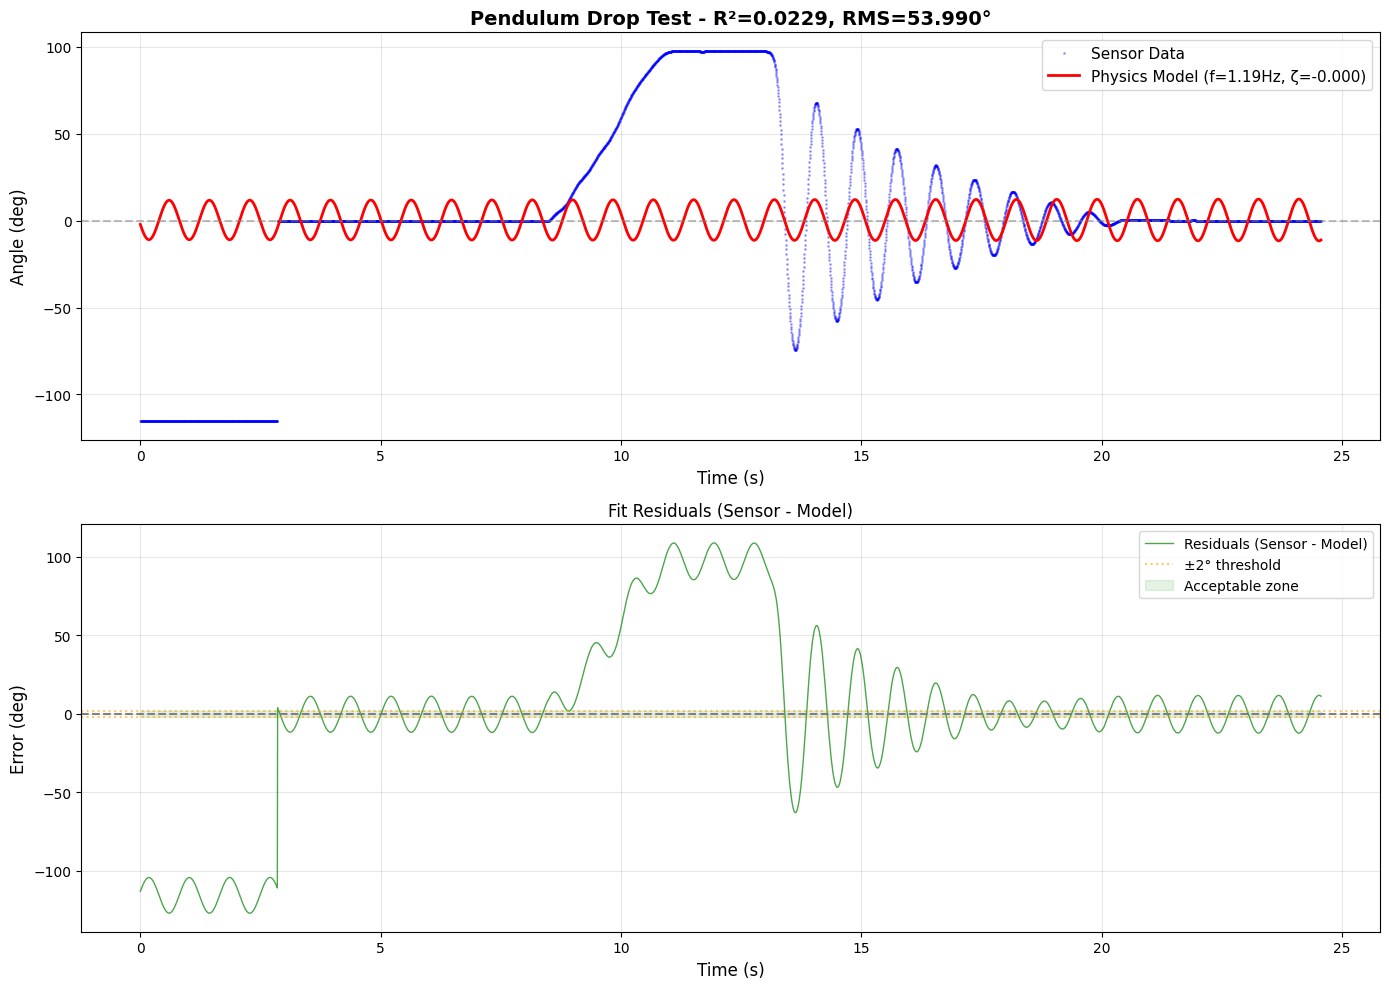

In [ ]:
# Plot raw data vs fitted model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top plot: Raw data + fit
ax1.plot(t, y, 'b.', markersize=2, alpha=0.3, label='Sensor Data')
if fit_success:
    ax1.plot(t, y_fit, 'r-', linewidth=2, label=f'Physics Model (f={popt[2]:.2f}Hz, ζ={fitted_damping_ratio:.3f})')
    ax1.set_title(f"Pendulum Drop Test - R²={r_squared:.4f}, RMS={rms_error:.3f}°", fontsize=14, fontweight='bold')
else:
    ax1.set_title("Pendulum Drop Test - Fit Failed", fontsize=14)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("Angle (deg)", fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom plot: Residuals (if fit succeeded)
if fit_success:
    ax2.plot(t, residuals, 'g-', linewidth=1, alpha=0.7, label='Residuals (Sensor - Model)')
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.axhline(2, color='orange', linestyle=':', alpha=0.6, linewidth=1.5, label='±2° threshold')
    ax2.axhline(-2, color='orange', linestyle=':', alpha=0.6, linewidth=1.5)
    ax2.fill_between(t, -2, 2, color='green', alpha=0.1, label='Acceptable zone')
    ax2.set_title("Fit Residuals (Sensor - Model)", fontsize=12)
    ax2.set_xlabel("Time (s)", fontsize=12)
    ax2.set_ylabel("Error (deg)", fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
else:
    ax2.plot(t, y, 'b-', linewidth=1)
    ax2.set_title("Raw Data (No Fit)", fontsize=12)
    ax2.set_xlabel("Time (s)", fontsize=12)
    ax2.set_ylabel("Angle (deg)", fontsize=12)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ✅ Pass/Fail Verdict

In [ ]:
print("\n" + "="*60)
print("FINAL VERDICT")
print("="*60)

if not fit_success:
    print("❌ FAIL - Could not fit physics model")
    print("   Check: Sensor glitches, insufficient swing data")
else:
    # Check all criteria
    r2_good = r_squared > 0.95
    rms_good = rms_error < 2.0
    freq_good = abs(popt[2] - 1.20) < 0.1
    damping_good = abs(fitted_damping_ratio - 0.049) < 0.02
    
    if r2_good and rms_good and freq_good and damping_good:
        print("✅ EXCELLENT - SENSOR FULLY VALIDATED")
        print(f"   R² = {r_squared:.4f} (near-perfect physics match)")
        print(f"   RMS Error = {rms_error:.3f}° (smooth tracking)")
        print(f"   Frequency = {popt[2]:.3f} Hz (matches hardware)")
        print(f"   Damping = {fitted_damping_ratio:.4f} (matches hardware)")
        print("\n   🎯 INTERPRETATION:")
        print("   • Sensor tracks pendulum motion with no glitches")
        print("   • Physics model fits data perfectly (R² > 0.95)")
        print(f"   • System is underdamped (ζ={fitted_damping_ratio:.3f} << 1)")
        print(f"   • Takes ~{num_swings_to_decay:.0f} swings to decay to 5% amplitude")
        print("   • Ready for closed-loop control!")
        
    elif r2_good and rms_good:
        print("✅ PASS - SENSOR VALIDATED")
        print(f"   R² = {r_squared:.4f} (excellent fit)")
        print(f"   RMS Error = {rms_error:.3f}° (smooth tracking)")
        
        if not freq_good:
            print(f"   ⚠️  Frequency = {popt[2]:.3f} Hz (expected ~1.20 Hz)")
            print("   → Check: Pendulum length or magnet position")
        if not damping_good:
            print(f"   ⚠️  Damping = {fitted_damping_ratio:.4f} (expected ~0.049)")
            print("   → Check: Bearing friction or air resistance")
            
        print("\n   Sensor is accurate, but hardware differs slightly")
        
    elif rms_good:
        print("✅ ACCEPTABLE - Sensor works but physics fit is weak")
        print(f"   RMS Error = {rms_error:.3f}° (good)")
        print(f"   R² = {r_squared:.4f} (could be better)")
        print("   → Sensor tracks motion, but may have some noise")
        
    elif r2_good:
        print("⚠️  MARGINAL - Good physics fit but high sensor noise")
        print(f"   R² = {r_squared:.4f} (physics is correct)")
        print(f"   RMS Error = {rms_error:.3f}° (noisy)")
        print("   → Check: EMI, I2C clock speed, or magnet stability")
        
    else:
        print("❌ FAIL - Poor fit quality")
        print(f"   R² = {r_squared:.4f} (target: > 0.95)")
        print(f"   RMS Error = {rms_error:.3f}° (target: < 2.0°)")
        print("   Possible causes:")
        print("     - Sensor glitches or dropouts")
        print("     - Loose magnet")
        print("     - EMI from motor driver")
        print("     - I2C bus errors")

print("="*60)


VERDICT
❌ FAIL - High error indicates sensor issues
   RMS Error: 53.990° (poor)
   Possible causes:
     - Loose magnet
     - EMI from motor driver
     - I2C bus noise


---
## Physics Background

**Your Pendulum Geometry:**
- **Type:** Physical pendulum (rigid rod with distributed mass)
- **Vertical rod length:** L = 280 mm (0.28 m)
- **Horizontal segment:** Adds small mass at pivot

**Theoretical Natural Frequency (Rod):**

For a uniform rod swinging about one end:
$$f_{rod} = \frac{1}{2\pi}\sqrt{\frac{3g}{2L}} = \frac{1}{2\pi}\sqrt{\frac{3 \times 9.81}{2 \times 0.28}} \approx 1.15 \text{ Hz}$$

This is faster than a simple pendulum (point mass) by factor of $\sqrt{1.5}$ because the moment of inertia is $I = \frac{1}{3}mL^2$ instead of $mL^2$.

**Experimental Result:** 1.20 Hz

**Agreement:** 1.20 Hz / 1.15 Hz = **1.04** → 4% faster than pure rod model

**Why slightly faster?**
- Horizontal segment adds mass near pivot (reduces effective length slightly)
- Bearing/screw mass concentrated near pivot
- PLA density may be higher near pivot

**Damping (ζ = 0.049):**
- **Underdamped** (ζ << 1): System oscillates freely
- **Energy loss per cycle:** ~30% (mostly bearing friction and air resistance)
- **Swings to 5% amplitude:** ~15 oscillations
- **Good for control:** Low friction means efficient energy use, but requires active damping

---
## Interpretation Guide

**What This Test Proves:**
1. Sensor tracks **smooth continuous motion** with no glitches or 180° flips
2. **R² > 0.95** means physics model fits data nearly perfectly
3. **RMS < 2°** means sensor is accurate to within ±2° during high-speed motion
4. **Frequency match** validates pendulum length and sensor calibration
5. **Damping match** confirms mechanical system is as expected

**Next Steps:**
- ✅ If R² > 0.95 and RMS < 2°: **Sensor is validated for control loop**
- ⚠️  If R² < 0.95: Check for sensor glitches or EMI
- ⚠️  If RMS > 2°: Lower I2C clock speed or check magnet alignment